### Convert SDO/AIA data from level 1 to level 1.5

AIA data products provides by the JSOC are level 1 data products.  
This means that the images still include the roll angle of the satellite and each channel may have a slightly different pixel scale.  
Typically, before performing any sort of data analysis on AIA images, you will want to promote your AIA data from level 1 to level 1.5.

1. Pointing correction (aiapy.calibrate.update_pointing)  
2. Image respiking (aiapy.calibrate.respike)  
3. PSF deconvolution (aiapy.psf.deconvolve)  
4. Registration (aiapy.calibrate.register)  
5. Degradation correction (aiapy.calibrate.correct_degradation)  
6. Exposure normalization

In this code, we only use method 1, 4, 5, and 6.

Reference.
https://aiapy.readthedocs.io/en/stable/preparing_data.html

In [1]:
import numpy as np

import astropy.units as u

import sunpy

import aiapy
from aiapy.calibrate.util import get_pointing_table
from aiapy.calibrate.util import get_correction_table

from convert_to_level1_5 import convert_to_level1_5

__all__ = ["update_pointing"]

In [2]:
"""gool quality"""
# level 1
#fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\193\2017\aia.lev1_euv_12s.2017-08-10T000006Z.193.image_lev1.fits"

"""bad quality"""
# # name 'strip_invalid_blank' is not defined
fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\193\2013\aia.lev1_euv_12s.2013-11-01T000008Z.193.image_lev1.fits"
# -> 해결됨.

# No valid entries for 2013-02-04T12:00:07.838 in pointing table with first T_START date and a last T_STOP date
#fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\193\2012\aia.lev1_euv_12s.2012-12-30T120008Z.193.image_lev1.fits"
# -> 해결됨.

# Input must be a full disk image.
#fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\193\2019\aia.lev1_euv_12s.2019-07-24T120005Z.193.image_lev1.fits"
# -> 어쩔 수 없음.

# Failed to read
# aia.lev1_euv_12s.2020-12-17T000006Z.193.image_lev1.fits
# aia.lev1_euv_12s.2024-12-23T120006Z.193.image_lev1.fits
# aia.lev1_euv_12s.2017-04-25T235959Z.211.image_lev1.fits
# aia.lev1_euv_12s.2020-12-18T235959Z.211.image_lev1.fits
# aia.lev1_euv_12s.2024-12-19T235959Z.211.image_lev1.fits
#fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\193\2020\aia.lev1_euv_12s.2020-12-17T000006Z.193.image_lev1.fits"
# -> 안 열림

# unsupported operand type(s) for *: 'NoneType' and 'Unit'
# aia.lev1_euv_12s.2021-03-18T235959Z.211.image_lev1.fits 
# aia.lev1_euv_12s.2021-04-29T115959Z.211.image_lev1.fits 
#fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\211\2021\aia.lev1_euv_12s.2021-03-18T235959Z.211.image_lev1.fits"
# -> 안 열림

aia_map = sunpy.map.Map(fits_file)
type(aia_map)

sunpy.map.sources.sdo.AIAMap

#### 1. Pointing correction

aiapy.calibrate.update_pointing(smap, *, pointing_table)

pointing_table = ``get_pointing_table``  
: This method removes any ``PCi_j`` matrix keys in the header and updates the ``CROTA2`` keyword.

In [3]:
pointing_tbl = get_pointing_table(
    "lmsal",
    time_range=(aia_map.date - 6*u.hour, aia_map.date + 6*u.hour)
)
aia_map.meta["SAT_ROT"] = 0.0 if aia_map.meta.get("SAT_ROT") is None

aia_map_pt = aiapy.calibrate.update_pointing(aia_map, pointing_table=pointing_tbl)

SyntaxError: expected 'else' after 'if' expression (191621327.py, line 5)

In [ ]:
# To check a change.
# CRPIX: reference point
# CDELT: 
for key in ["CRPIX1","CRPIX2","CDELT1","CDELT2", "CROTA2"]:
    print(key, "before:", aia_map.meta[key], "after:", aia_map_pt.meta[key])


CRPIX1 before: 2037.71753 after: 2037.717529
CRPIX2 before: 2041.74365 after: 2041.743652
CDELT1 before: 0.600758016 after: 0.600758
CDELT2 before: 0.600758016 after: 0.600758
CROTA2 before: 0.0564329997 after: 0.056433


#### 2. Registration

In [ ]:
aia_map_reg = aiapy.calibrate.register(
    aia_map_pt,
    missing=np.nan,     # extrapolation: fill with NaN
    order=3,            # interpolation: bicubic        
    method='scipy'      # Rotation function to use: scipy
)

In [ ]:
# To check a change.
for key in ["CRPIX1","CRPIX2","CDELT1","CDELT2"]:
    print(key, "before:", aia_map_pt.meta[key], "after:", aia_map_reg.meta[key])

CRPIX1 before: 2042.022095 after: 2048.5
CRPIX2 before: 2042.644165 after: 2048.5
CDELT1 before: 0.600714 after: 0.6
CDELT2 before: 0.600714 after: 0.6


#### 3. Degradation correction

In [ ]:
corr_tbl = get_correction_table("SSW")

aia_map_cal = aiapy.calibrate.correct_degradation(
    aia_map_reg,
    correction_table=corr_tbl
)

In [ ]:
print("before:", aia_map_reg.date.isot, " after:", aia_map_cal.date.isot)

before: 2013-02-04T12:00:06.838  after: 2013-02-04T12:00:06.838


#### 4. Exposure normalization

In [ ]:
exp_time = aia_map_cal.exposure_time

aia_map_norm = aia_map_cal / exp_time

Observatory,SDO
Instrument,AIA 2
Detector,AIA
Measurement,193.0 Angstrom
Wavelength,193.0 Angstrom
Observation Date,2013-02-04 12:00:06
Exposure Time,1.999592 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.6 0.6] arcsec / pix
Reference Pixel,[2047.5 2047.5] pix

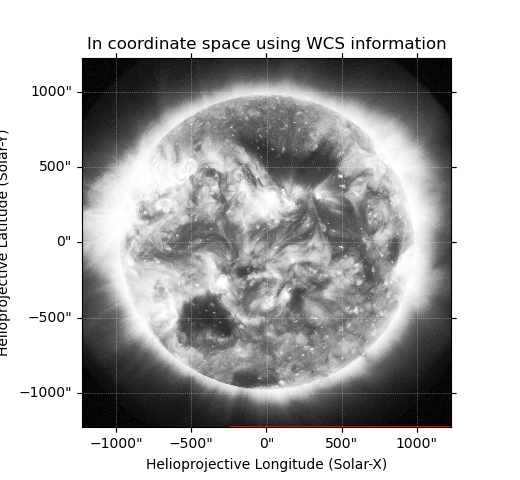
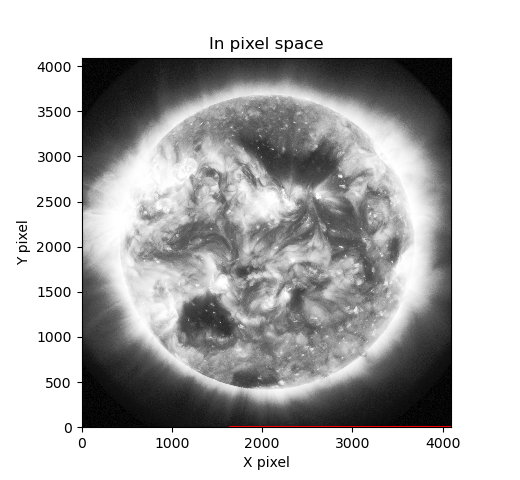
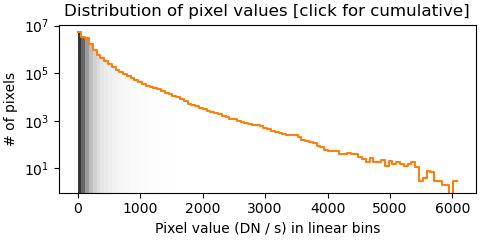
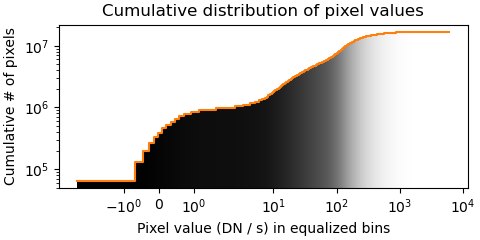

In [ ]:
aia_map_norm

---

In [53]:
from astropy.io import fits

channel = "193"
year = "2013"
fits_filename = "aia.lev1_euv_12s.2013-06-21T000008Z.193.image_lev1.fits"

fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\{}\{}\{}".format(channel, year, fits_filename)
hdul = fits.open(fits_file)
print("BITPIX =", hdul[1].header['BITPIX'], '\n', hdul[1].data)

BITPIX = 16 
 [[ 0.  1. -1. ...  1.  0.  0.]
 [-1.  0. -1. ...  0. -1. -1.]
 [ 0.  0. -1. ...  1. -1.  0.]
 ...
 [-1. -1. -1. ... -1.  0.  2.]
 [-1.  0.  0. ...  0.  0.  1.]
 [ 0.  2.  1. ... -2. -1. -1.]]


In [49]:
hdul[1].header

XTENSION= 'IMAGE   '                                                            
BITPIX  =                   16 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 4096 / length of original image axis                  
NAXIS2  =                 4096 / length of original image axis                  
PCOUNT  =                    0                                                  
GCOUNT  =                    1                                                  
BLD_VERS= 'V8R0X'                                                               
LVL_NUM =                   1. / LVL_NUM data level number                      
T_REC   = '2013-06-21T00:00:01.000' / [ISO] Slotted observation time            
TRECSTEP=                  12. / [second] T_REC step {T_REC_step}               
TRECEPOC= '1993.01.01_00:00:04.000_TAI' / [TAI]                                 
TRECROUN=                   

In [64]:
from astropy.io import fits
channel = "193"
year = "2013"
fits_filename = "aia.lev1_5_euv_12s.2013-06-21T000008Z.193.image_lev1_5.fits"

fits_file = r"D:\Research_data\EUV\{}\{}\{}".format(channel, year, fits_filename)
hdul = fits.open(fits_file)
print("BITPIX =", hdul[0].header['BITPIX'], '\n', hdul[0].data)

BITPIX = -64 
 [[        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ... -0.81723681 -1.29530672
   0.04553512]
 ...
 [        nan         nan         nan ...  0.800099    0.9460633
   0.03813855]
 [        nan         nan         nan ... -0.86163769  0.52450482
   0.60146334]
 [        nan         nan         nan ... -0.04745141 -0.1023546
  -0.04008268]]


##### Manually Converting to a Level 1.5 FITS File

In [9]:
from sunpy.time import parse_time
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
import sunpy

from convert_to_level1_5 import convert_to_level1_5

import time


In [27]:
channel = "193"
year = "2013"
fits_filename = "aia.lev1_euv_12s.2013-06-21T120008Z.193.image_lev1.fits"

fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\{}\{}\{}".format(channel, year, fits_filename)
aia_map = sunpy.map.Map(fits_file, allow_errors=True)
#destination_dir = Path("D:\Research_data\EUV") / str(channel)/ str(year)
#outfile = str(destination_dir / fits_file.name.replace("lev1", "lev1_5"))

#aia_map_new = convert_to_level1_5(aia_map)
#aia_map_new.save(outfile, overwrite=False)
aia_map

decompression error: hit end of compressed byte stream [sunpy.map.map_factory]
2025-04-21 11:13:20 - sunpy - WARNING: SunpyUserWarning: Failed to read E:\Research\SR\input\CH_Indices\EUV_level1\193\2013\aia.lev1_euv_12s.2013-06-21T120008Z.193.image_lev1.fits
decompression error: hit end of compressed byte stream


RuntimeError: No maps loaded

In [19]:
from astropy.io import fits

In [26]:
hdul = fits.open(fits_file,
                ignore_missing_end=True,
                do_not_scale_image_data=True)
print(hdul[1].data)

CfitsioException: decompression error: hit end of compressed byte stream

---

In [8]:
# parameters
channels = [193, 211]
start_dt = parse_time("2012-01-01").to_datetime()
end_dt = parse_time("2013-12-31").to_datetime()
file_directory = r"E:\Research\SR\input\CH_Indices\EUV_level1"
save_directory = r"D:\Research_data\EUV"
parent_dir = Path(file_directory)
save_dir   = Path(save_directory)

years = range(start_dt.year, end_dt.year + 1)

def strip_invalid_blank(aia_map):
    """
    Remove the BLANK keyword when BITPIX < 0 (float data),
    to avoid astropy VerifyWarning.
    """
    if aia_map.meta.get("BITPIX", 0) < 0 and "BLANK" in aia_map.meta:
        aia_map.meta.pop("BLANK") 

for chan in channels:
    for year in years:
        source_dir = parent_dir / str(chan) / str(year)
        destination_dir = save_dir / str(chan)/ str(year)
        destination_dir.mkdir(parents=True, exist_ok=True)

        source_files = sorted(source_dir.glob("*.fits"))
        destination_files = []

        with tqdm(source_files, desc=f"EUV {chan} | year={year}", unit="file") as pbar:
            for file in pbar:
                pbar.set_postfix(file=file.name[:60])
                try:
                    file_date = datetime.strptime(file.stem.split(".")[2],
                                               "%Y-%m-%dT%H%M%SZ")
                except Exception:
                    continue
                if not (start_dt <= file_date <= end_dt):
                    continue
                outfile = destination_dir / file.name.replace("lev1", "lev1_5")
                if outfile.exists():
                    continue

                destination_files.append((str(file), str(outfile)))
                try:
                    t0 = time.perf_counter()
                    aia_map = sunpy.map.Map(file)
                    t1 = time.perf_counter()
                    aia_map_new = convert_to_level1_5(aia_map)
                    t2 = time.perf_counter()
                    strip_invalid_blank(aia_map_new)
                    t3 = time.perf_counter()
                    aia_map_new.save(outfile, overwrite=False)
                    t4 = time.perf_counter()
                    print(f"{file.name}: "
                        f"Map: {t1-t0:.2f}s, "
                        f"Convert: {t2-t1:.2f}s, "
                        f"strip_invalid_blank: {t3-t2:.2f}s, "
                        f"Save: {t4-t3:.2f}s")
                except Exception as e:
                    pbar.write(f"[{chan}] {file.name} failed: {e}")
print("All conversions finished.")

EUV 193 | year=2012:   0%|          | 1/733 [00:06<1:24:21,  6.91s/file, file=aia.lev1_euv_12s.2012-01-01T120009Z.193.image_lev1.fits]

aia.lev1_euv_12s.2012-01-01T000009Z.193.image_lev1.fits: Map: 0.27s, Convert: 5.91s, strip_invalid_blank: 0.00s, Save: 0.73s


EUV 193 | year=2012:   0%|          | 2/733 [00:13<1:24:25,  6.93s/file, file=aia.lev1_euv_12s.2012-01-02T000009Z.193.image_lev1.fits]

aia.lev1_euv_12s.2012-01-01T120009Z.193.image_lev1.fits: Map: 0.27s, Convert: 5.94s, strip_invalid_blank: 0.00s, Save: 0.73s


EUV 193 | year=2012:   0%|          | 3/733 [00:20<1:24:35,  6.95s/file, file=aia.lev1_euv_12s.2012-01-02T120009Z.193.image_lev1.fits]

aia.lev1_euv_12s.2012-01-02T000009Z.193.image_lev1.fits: Map: 0.27s, Convert: 5.98s, strip_invalid_blank: 0.00s, Save: 0.73s


EUV 193 | year=2012:   0%|          | 3/733 [00:22<1:30:37,  7.45s/file, file=aia.lev1_euv_12s.2012-01-02T120009Z.193.image_lev1.fits]


KeyboardInterrupt: 